In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import gamma

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeTorino

from HDT_circuit_qiskit import HEA_circuit_sampler

sns.set()

In [ ]:
def get_cond_prob(bit_string_counts):
    # convert count dict to pd frame
    df = pd.DataFrame.from_dict(
        bit_string_counts, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['data_bits'] = df['bits'].str[:2]
    df['bath_bits'] = df['bits'].str[2:]
    df = df.drop('bits', axis=1)

    # find result with 00 data bit
    A0_bits = df[df['data_bits'] == '00']
    A0_bits = A0_bits.rename(
        columns={'counts': 'cond_counts'}).drop('data_bits', axis=1)

    # compute cond prob using left merge
    ZB_df = df.groupby('bath_bits').sum(numeric_only=True).reset_index()
    ZB_df = ZB_df.merge(A0_bits, on='bath_bits', how='left').fillna(0)
    ZB_df['cond_prob'] = ZB_df['cond_counts'] / ZB_df['counts']
    ZB_df = ZB_df.drop(['cond_counts', 'bath_bits'], axis=1)

    # expand into long format
    ZB_df = ZB_df.reindex(ZB_df.index.repeat(ZB_df['counts']))

    return ZB_df['cond_prob'].to_numpy()

## Example: 2 + 2 Qubits, HEA circuit

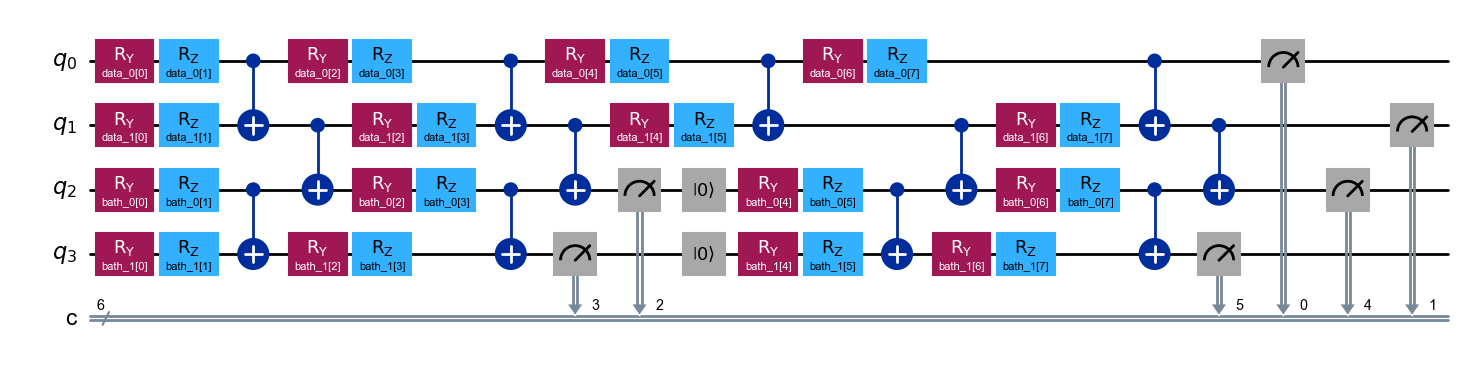

In [3]:
# plot a simple circuit
circuit = HEA_circuit_sampler(2, 2, 2, 2)
circuit.draw('mpl')

In [4]:
# new circuit
n_step = 5
n_depth = 4
n_data = 2
n_bath = 2

circuit = HEA_circuit_sampler(n_step, n_depth, n_data, n_bath)

In [5]:
# generate random params
n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
bound_circuit = circuit.assign_parameters(param_random)

In [6]:
# simulate
job = AerSimulator().run(bound_circuit, shots=1e4)
res = job.result().get_counts(bound_circuit)
phat = get_cond_prob(res)

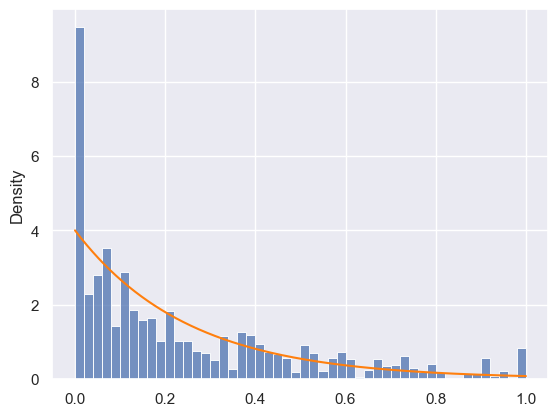

In [7]:
z = np.linspace(0, 1, 1000)
pt_dist = gamma.pdf(z, 1, scale=0.25)

sns.histplot(phat, bins=50, stat='density')
plt.plot(z, pt_dist, color='tab:orange')

## Multiple Histograms


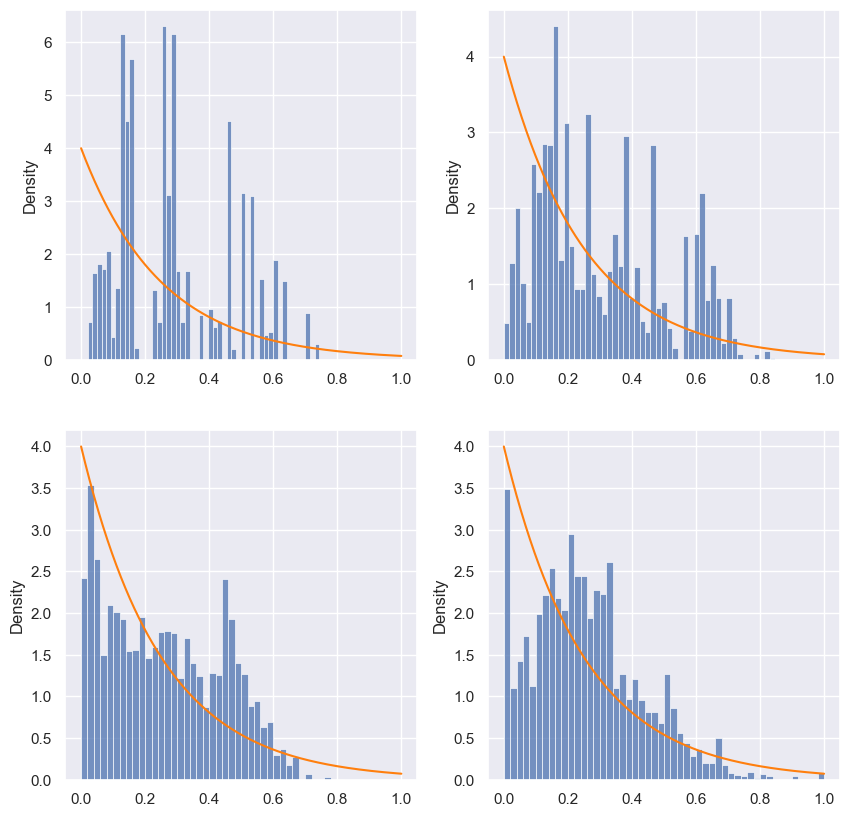

In [ ]:
shots = 1e5
n_data = 2
n_bath = 2

n_depth = 5


z = np.linspace(0, 1, 1000)

pt_dist = gamma.pdf(z, 1, scale=0.25)


steps = [3, 4, 5, 6]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, n_step in enumerate(steps):

    # setup

    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)

    circuit = HEA_circuit_sampler(n_step, n_depth, n_data, n_bath)

    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)

    bound_circuit = circuit.assign_parameters(param_random)


    # simulate

    job = AerSimulator().run(bound_circuit, shots=shots)

    res = job.result().get_counts(bound_circuit)

    phat = get_cond_prob(res)


    # plot

    sns.histplot(phat, bins=50, stat='density', ax=ax[i // 2, i % 2])

    ax[i // 2, i % 2].plot(z, pt_dist, color='tab:orange')

## Noise Simulation

In [9]:
backend = FakeTorino()
backend_sim = AerSimulator.from_backend(backend)

In [10]:
# new circuit
n_step = 5
n_depth = 4
n_data = 2
n_bath = 2

circuit = HEA_circuit_sampler(n_step, n_depth, n_data, n_bath)
transpiled_circuit = transpile(circuit, backend)

n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
bound_circuit = transpiled_circuit.assign_parameters(param_random)

job = backend_sim.run(bound_circuit, shots=1e5)
res = job.result().get_counts(bound_circuit)
phat = get_cond_prob(res)

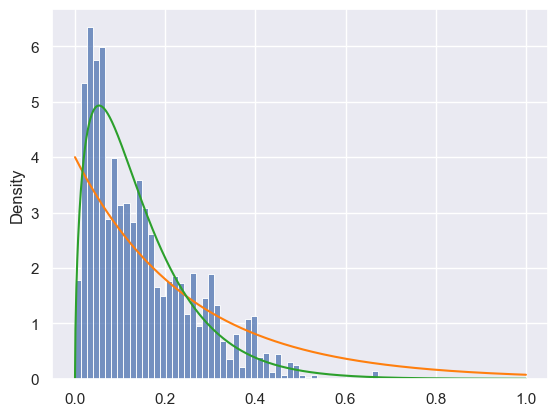

In [12]:
# fit a gamma density
z = np.linspace(0, 1, 1000)
pt_dist = gamma.pdf(z, 1, scale=0.25)

mean = phat.mean()
alpha = mean ** 2. / phat.var()
beta = mean / alpha
ga_dist = gamma.pdf(z, alpha, scale=beta)

sns.histplot(phat, bins=50, stat='density')
plt.plot(z, pt_dist, color='tab:orange')
plt.plot(z, ga_dist, color='tab:green');